### Import standard modules

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

### Import NiPy modules

In [5]:
import nipy
import nibabel as nib
import dipy
import nilearn
import nipype

### Load up some sample data

In [9]:
t1img = nib.load('./MNI152_T1_1mm.nii.gz')

In [32]:
type(t1img)

nibabel.nifti1.Nifti1Image

In [14]:
t1data = t1img.get_data()

In [31]:
type(t1data)

numpy.ndarray

In [15]:
t1data.shape

(182, 218, 182)

In [16]:
t1img.affine

array([[  -1.,    0.,    0.,   90.],
       [   0.,    1.,    0., -126.],
       [   0.,    0.,    1.,  -72.],
       [   0.,    0.,    0.,    1.]])

The image object contains the metadata associated with the scan. Late we will learn to manipulate the affine matrix

### Load up a mask

In [17]:
maskimg = nib.load('./JHU-ICBM-labels-1mm.nii.gz')

In [18]:
maskdata = maskimg.get_data()

In [19]:
maskdata.shape

(182, 218, 182)

### t1data and maskdata are both just numpy 3D arrays, so we perform normal array operations

In [20]:
maskdata.max()

48

In [21]:
maskdata.min()

0

In [23]:
t1data[maskdata==48].mean()

5780.791666666667

Let's make a copy of t1data and zero out voxels where maskdata==48

In [24]:
t1data2 = t1data.copy()

In [25]:
t1data2[maskdata==48] = 0

In [27]:
t1data2[maskdata==48].mean()

0.0

### Save the modified image

In [33]:
t1img2 = nib.Nifti1Image(t1data2,t1img.affine)

In [34]:
nib.save(t1img2,'t1img2.nii.gz')

### Nibabel has tools for opening multiple formats including PAR/REC
Loading a PAR/REC image with nibabel and then saving to nifti is, in my experience, more robust than dcm2nii

In [35]:
nib.parrec?

In [36]:
nib.load?

### Visualizing images

<IPython.core.display.Javascript object>


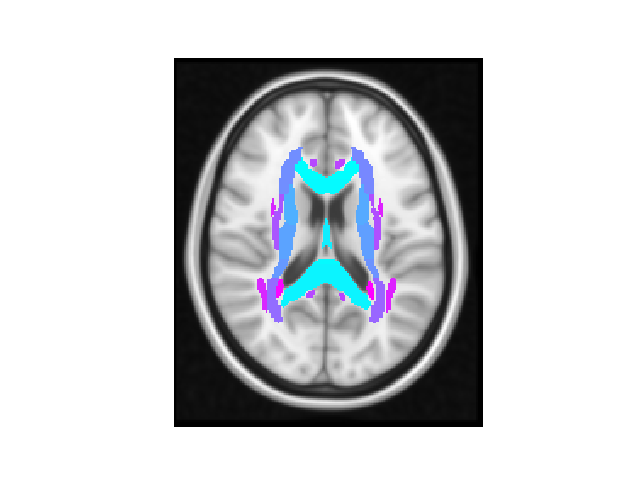

(-0.5, 181.5, 217.5, -0.5)

In [60]:
%matplotlib notebook
f,ax = plt.subplots()
sl=90
t1im = ax.matshow(np.rot90(t1data[:,:,sl]),cmap='gray')
ax.axis('off')

### Can we overly the JHU atlas?

In [61]:
maskim = ax.matshow(np.rot90(maskdata[:,:,sl]),cmap='cool')

In [62]:
maskim.remove()

In [63]:
maskdata_masked = np.ma.masked_equal(maskdata,0)

In [64]:
maskdata_masked;

In [65]:
maskim = ax.matshow(np.rot90(maskdata_masked[:,:,sl]),cmap='cool')

### Let's return a pandas dataframe with the mean values for each ROI

In [96]:
means = []
for i in range(maskdata.max()):
    mean = t1data[maskdata==i].mean()
    means.append(mean)

In [73]:
means;

### Not very "pythonic". Avoid loops when you can do it in one line!

In [94]:
means = [ t1data[maskdata==i].mean() for i in range(1,maskdata.max()+1)]

In [75]:
means;

In [83]:
df = pd.DataFrame(data=means,columns=['Subject 1'],index=range(1,maskdata.max()+1))

In [84]:
df.head()

,Subject 1
1,6689.230887
2,6503.092667
3,7291.812338
4,7010.265116
5,7069.381570


In [85]:
len(df)

48

Do this for multiple subjects and you've started building a database that you can run stats on, save to Excel, etc.

In [87]:
pd.DataFrame?

## Manipulating the affine
The affine matrix describes the relationship between the image matrix and the "real world" coordinate system. Image orientation manipulation should be approached with caution, but it's often necessary.

In [97]:
t1img.affine

array([[  -1.,    0.,    0.,   90.],
       [   0.,    1.,    0., -126.],
       [   0.,    0.,    1.,  -72.],
       [   0.,    0.,    0.,    1.]])

In [101]:
canonical_t1img = nib.as_closest_canonical(t1img)
canonical_t1img.affine

array([[   1.,    0.,    0.,  -91.],
       [   0.,    1.,    0., -126.],
       [   0.,    0.,    1.,  -72.],
       [   0.,    0.,    0.,    1.]])

In [104]:
canonical_t1img.shape

(182, 218, 182)

In [105]:
t1img.shape

(182, 218, 182)